In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges, gen_num_edges_undirected
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re
from matplotlib.transforms import Affine2D

In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
all_methods = [
  "brute('BRANCH_N_BOUND')",
  "brute('BRUTE_FORCE')",
  "brute('BRUTE_FORCE_COMPLETE')",
  "brute('FAST_BOUND')",
  "ilp()",
  "kalp()",
  "kalp(threads=4)"
]

method_name_dict = {
  "brute('BRANCH_N_BOUND')" : "Branch and bound",
  "brute('BRUTE_FORCE')" : "Brute force",
  "brute('BRUTE_FORCE_COMPLETE')" : "Brute force (complete)",
  "brute('FAST_BOUND')" : "Fast bound",
  "ilp()" : "ILP",
  "kalp()" : "KaLP single threaded",
  "kalp(threads=4)" : "KaLP on 4 threads",
}

color_assignment = {method : col for method, col in zip(all_methods, colors)}
color_assignment

{"brute('BRANCH_N_BOUND')": '#1f77b4',
 "brute('BRUTE_FORCE')": '#ff7f0e',
 "brute('BRUTE_FORCE_COMPLETE')": '#2ca02c',
 "brute('FAST_BOUND')": '#d62728',
 'ilp()': '#9467bd',
 'kalp()': '#8c564b',
 'kalp(threads=4)': '#e377c2'}

In [9]:
benchmark_low_degrees = Benchmark.load("../final_benchmarks/all_methods_1.2-3.6_50_runs_latest/")
benchmark_only_ham = Benchmark.load("../final_benchmarks/only_ham_3brute_ilp_kalp_deg1-10_50runs/")

In [4]:
def build_plotting_dataframes(benchmark: Benchmark):
  df = benchmark.get_dataframe()
  df_grouped = df \
    .groupby(['average_out_degree', 'solver', 'solver_name']) \
    .agg({
      "run_time": ["mean", "median", "std"], 
      "failure": "any"
    }) \
    .reset_index() \
    .rename(columns={"any": ""})

  df_grouped.columns = [a + ("_" + b if b != "" else "")  for (a,b) in df_grouped.columns]

  df_grouped_failures_removed = df_grouped[df_grouped["failure"] == False]
  to_plot = df_grouped_failures_removed.pivot(
    index='average_out_degree', 
    columns='solver_name', 
    values=['run_time_mean', 'run_time_std']
  ).reset_index()

  return df, df_grouped, df_grouped_failures_removed, to_plot

# Functions for plotting

In [5]:
def setup_info(to_plot):
    plt.title('Running time by average degree')
    plt.ylabel("run-time (seconds)")
    plt.xlabel("mean degree")
    methods = list(to_plot.columns.droplevel())
    plt.legend([method_name_dict[m] for m in methods[1:len(methods)//2+1]], loc='center left', bbox_to_anchor=(1, 0.5))
  
def plt_with_scatter(benchmark, offset_arg = None):
    df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

    fig, ax = plt.subplots()

    to_plot.plot(
        style="o-", 
        x="average_out_degree", 
        y="run_time_mean", 
        color=color_assignment, 
        ax=ax
    )

    offsets = offset_arg if offset_arg != None else [0 for _ in benchmark.solver_names()]

    for offset, solver_name in zip(offsets, benchmark.solver_names()):
        solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
        plt.scatter(
            solver_df['average_out_degree'] + offset,  
            solver_df['run_time'], 
            label=solver_name, 
            alpha=0.2, 
            s=7,
            color=color_assignment[solver_name]
        )
    setup_info(to_plot)


def plot_with_symmetric_errbars(benchmark, offsets_arg = None):
    df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

    fig, ax = plt.subplots()

    to_plot.plot(
        style="o-",
        x="average_out_degree",
        y="run_time_mean", 
        color=color_assignment,
        ax=ax,
    )

    offsets = offsets_arg if offsets_arg != None else [0 for _ in benchmark.solver_names()]

    for offset, solver_name in zip(offsets, benchmark.solver_names()):
        plt.errorbar(
        to_plot['average_out_degree'] + offset,
        to_plot['run_time_mean'][solver_name],
        yerr = to_plot['run_time_std'][solver_name],
        fmt='none',
        capsize=3,
        alpha=0.5,
        color=color_assignment[solver_name],
        )
    setup_info(to_plot)


# Plots for low degree benchmark

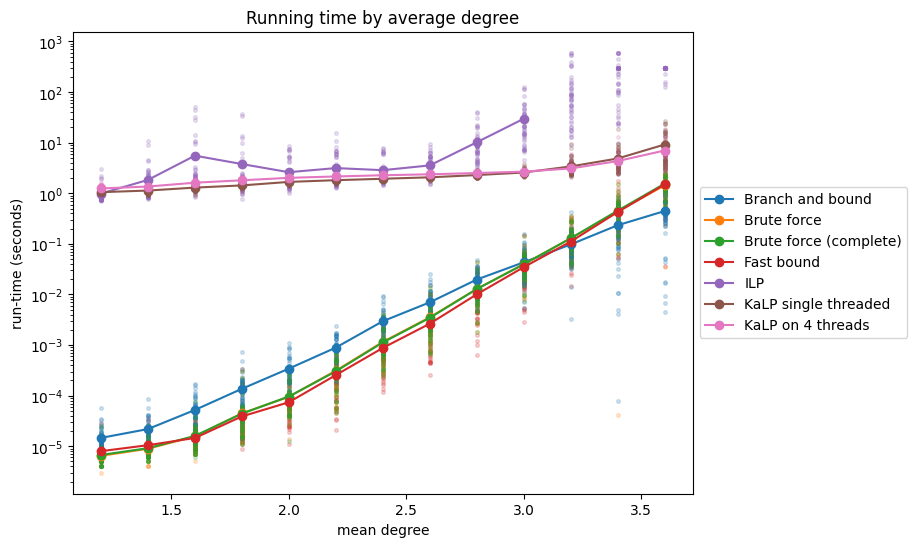

In [6]:
plt_with_scatter(benchmark_low_degrees)

plt.yscale('log')

plt.gcf().set_size_inches(8, 6)

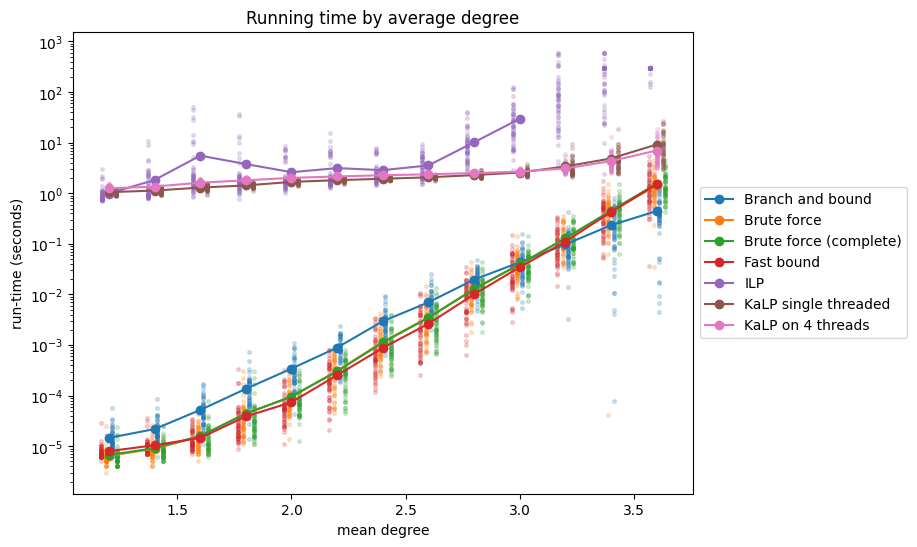

In [7]:
plt_with_scatter(benchmark_low_degrees, list(np.linspace(-0.035,0.035,4)) + list(np.linspace(-0.03,0.03,3)))

plt.yscale("log")
plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark_low_degrees.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

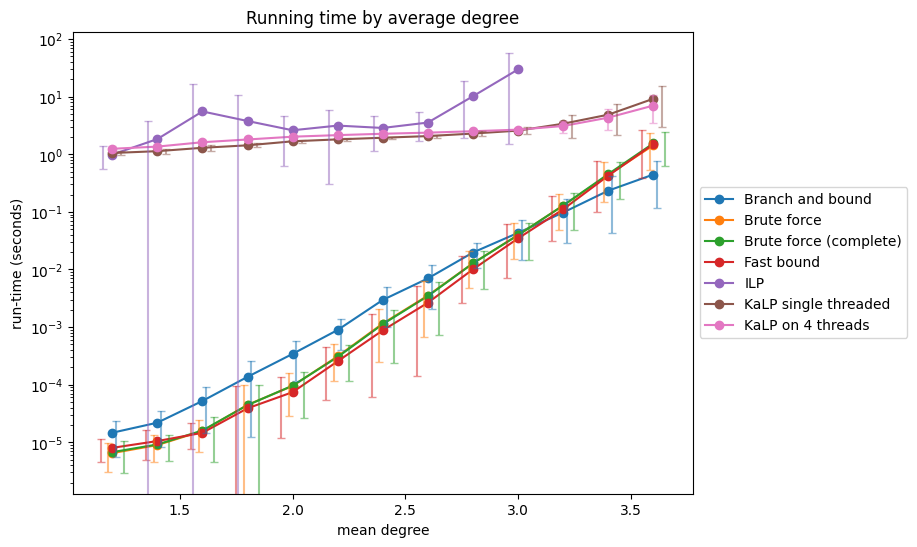

In [8]:
plot_with_symmetric_errbars(benchmark_low_degrees, list(np.linspace(-0.05,0.05,4)) + list(np.linspace(-0.04,0.04,3)))

plt.yscale("log")

plt.gcf().set_size_inches(8, 6)

# Plot for only Hamiltonian benchmark

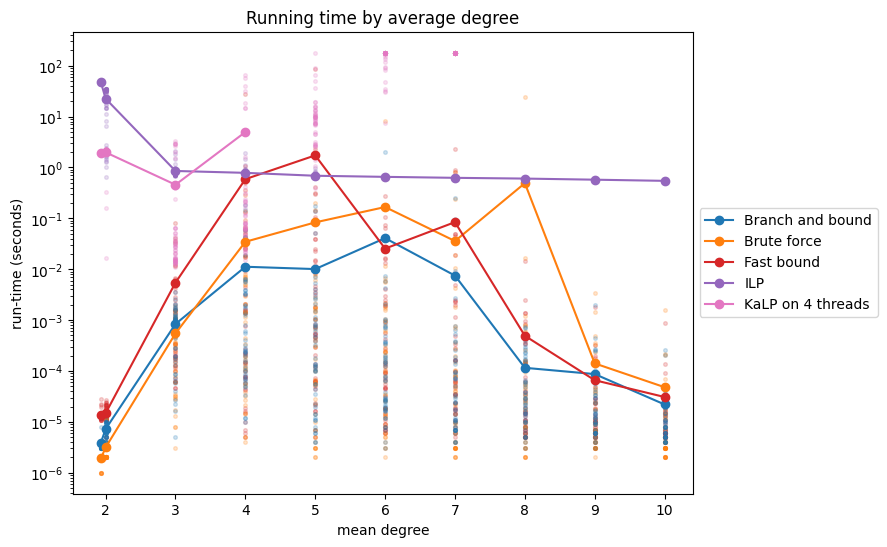

In [10]:
plt_with_scatter(benchmark_only_ham)

plt.yscale('log')

plt.gcf().set_size_inches(8, 6)

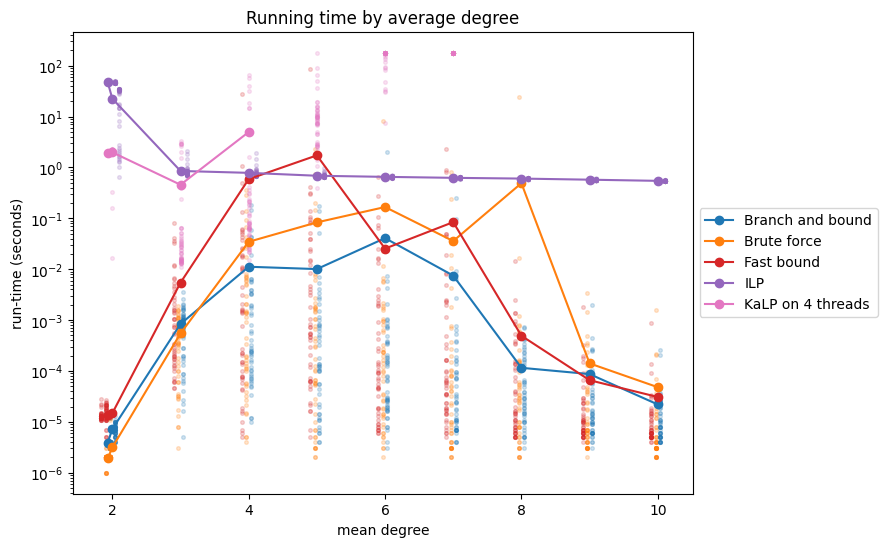

In [12]:
plt_with_scatter(benchmark_only_ham, list(np.linspace(-0.1,0.1,4)) + [0])

plt.yscale('log')

plt.gcf().set_size_inches(8, 6)

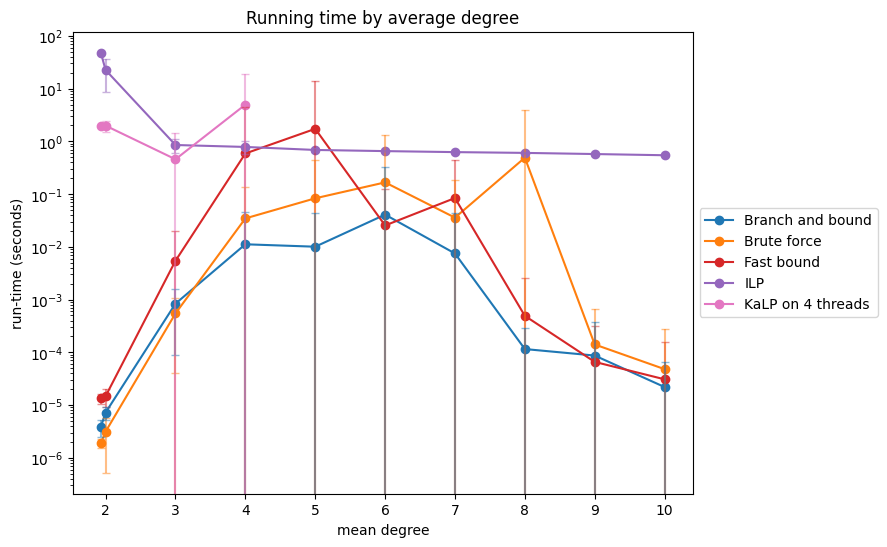

In [16]:
plot_with_symmetric_errbars(benchmark_only_ham)
plt.yscale('log')
plt.gcf().set_size_inches(8, 6)

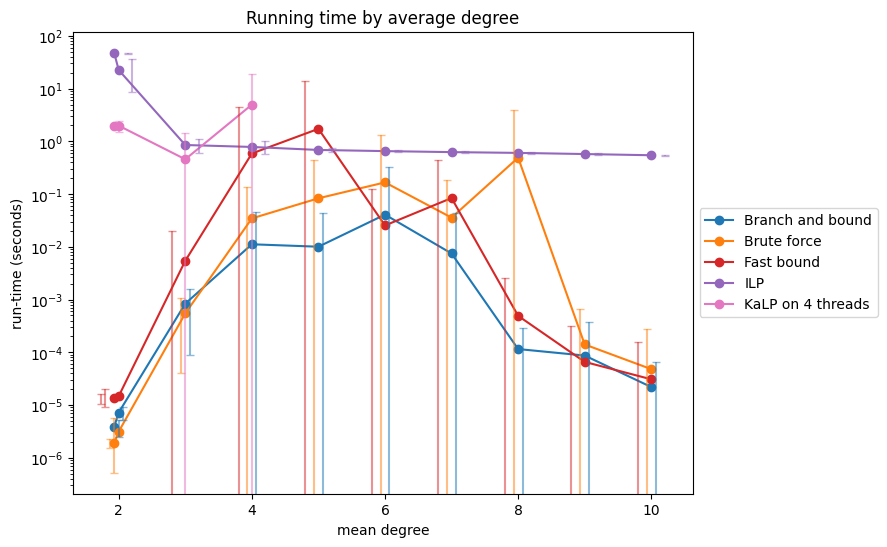

In [14]:
plot_with_symmetric_errbars(benchmark_only_ham, list(np.linspace(-0.2,0.2,4)) + [0])
plt.yscale('log')
plt.gcf().set_size_inches(8, 6)